In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for neural networks
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam


In [10]:
!which python3

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3


/Library/Frameworks/Python.framework/Versions/3.11/bin/python3 model/training_pipeline.py


In [11]:
!python3 -m pip show scikit-learn


Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: pingouin, shap


In [12]:
# Load the data
df = pd.read_csv("../data/insurance.csv")

df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# Data Preprocessing

Handling Missing Values: Although initial data checks may not show missing values, always prepare to implement strategies for handling them.

Feature Engineering: Create new features that might improve model performance, such as Body Mass Index (BMI) from height and weight.

Scaling and Encoding: Apply appropriate scaling to numerical features and encoding to categorical features to prepare the data for machine learning algorithms.


In [13]:
def preprocess_data(df: pd.DataFrame):
    df['Height_m'] = df['Height'] / 100
    df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)
    df.drop(columns=['Height_m'], inplace=True)

    bool_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
                 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
    df[bool_cols] = df[bool_cols].astype(int)

    df['NumberOfMajorSurgeries'] = df['NumberOfMajorSurgeries'].astype(str)
    le = LabelEncoder()
    df['NumberOfMajorSurgeries'] = le.fit_transform(df['NumberOfMajorSurgeries'])

    scaler = StandardScaler()
    scale_cols = ['Age', 'Height', 'Weight', 'BMI']
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    X = df.drop(columns=['PremiumPrice'])
    y = df['PremiumPrice']

    return X, y

# Model Selection

We’ll train and evaluate the following models to predict PremiumPrice:

Linear Regression – as a baseline.

Decision Tree Regressor – to capture non-linear relationships.

Random Forest Regressor – to improve performance using ensemble learning.

Gradient Boosting Regressor – for potentially higher accuracy with boosting.

We’ll also evaluate model performance using metrics like:

Mean Absolute Error (MAE)

Root Mean Squared Error (RMSE)

R² Score

In [15]:
def evaluate_model(model, X, y, name="Model"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores, mae_scores, r2_scores = [], [], []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))
        mae_scores.append(mean_absolute_error(y_val_fold, y_pred))
        r2_scores.append(r2_score(y_val_fold, y_pred))

    print(f"\n📊 {name} Evaluation:")
    print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
    print(f"Average MAE: {np.mean(mae_scores):.2f}")
    print(f"Average R²: {np.mean(r2_scores):.4f}")
    return model


In [16]:
def prediction_interval(model, X_test, y_test, confidence=0.95):
    # Assumes model has been fit
    from scipy.stats import norm

    predictions = model.predict(X_test)
    residuals = predictions - y_test
    std_error = np.std(residuals)

    z_score = norm.ppf((1 + confidence) / 2)
    margin = z_score * std_error

    lower = predictions - margin
    upper = predictions + margin

    return predictions, lower, upper


In [17]:

X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definitions
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Train and Evaluate
trained_models = {}
for name, model in models.items():
    trained = evaluate_model(model, X_train, y_train, name)
    trained_models[name] = trained


📊 Linear Regression Evaluation:
Average RMSE: 3864.02
Average MAE: 2763.67
Average R²: 0.5997

📊 Decision Tree Evaluation:
Average RMSE: 4166.07
Average MAE: 1219.40
Average R²: 0.5358

📊 Random Forest Evaluation:
Average RMSE: 3100.55
Average MAE: 1322.37
Average R²: 0.7339

📊 Gradient Boosting Evaluation:
Average RMSE: 3250.95
Average MAE: 1486.35
Average R²: 0.7136


Random Forest and Gradient Boosting have high Average R² compare to others, let perform more experiments on it.

In [18]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# 3. Randomized Search with CV
search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

# 4. Best CV score and parameters
print("Best CV R²:", search.best_score_)
print("Best Parameters:", search.best_params_)

# 5. Evaluate on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print("Test R²:", test_r2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV R²: 0.7204956412315369
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Test R²: 0.84772789478302


In [23]:
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from tqdm import tqdm

# Define your parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Store results
cv_r2_scores = []
test_r2_scores = []

# Number of repetitions
n_repeats = 3

for seed in tqdm(range(n_repeats), desc="Running evaluations"):
    # 1. Split the data differently each time
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    # 2. Perform RandomizedSearchCV on each split
    search = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=10,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        random_state=seed,
        verbose=0
    )
    
    search.fit(X_train, y_train)
    
    # 3. Evaluate on both CV and test
    cv_r2_scores.append(search.best_score_)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_r2_scores.append(r2_score(y_test, y_pred))

# Summary
print("\n--- Repeated Evaluation Summary ---")
print(f"Mean CV R²:   {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")
print(f"Mean Test R²: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")


Running evaluations: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


--- Repeated Evaluation Summary ---
Mean CV R²:   0.7696 ± 0.0101
Mean Test R²: 0.6941 ± 0.0820


In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Define param grids
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']  # corrected here
}

# Store results in dictionaries
results = {
    'XGBoost': {'cv_r2': [], 'test_r2': [], 'best_params': []},
    'RandomForest': {'cv_r2': [], 'test_r2': [], 'best_params': []}
}

n_repeats = 5

for seed in tqdm(range(n_repeats), desc="Running evaluations"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    # XGBoost RandomizedSearchCV
    xgb_search = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_distributions=xgb_param_grid,
        n_iter=10,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        random_state=seed,
        verbose=0
    )
    xgb_search.fit(X_train, y_train)
    results['XGBoost']['cv_r2'].append(xgb_search.best_score_)
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)
    results['XGBoost']['test_r2'].append(r2_score(y_test, y_pred_xgb))
    results['XGBoost']['best_params'].append(xgb_search.best_params_)

    # Random Forest RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=rf_param_grid,
        n_iter=10,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        random_state=seed,
        verbose=0
    )
    rf_search.fit(X_train, y_train)
    results['RandomForest']['cv_r2'].append(rf_search.best_score_)
    best_rf = rf_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    results['RandomForest']['test_r2'].append(r2_score(y_test, y_pred_rf))
    results['RandomForest']['best_params'].append(rf_search.best_params_)

# Summary printout
for model_name in results:
    print(f"\n--- {model_name} Summary ---")
    print(f"Mean CV R²:   {np.mean(results[model_name]['cv_r2']):.4f} ± {np.std(results[model_name]['cv_r2']):.4f}")
    print(f"Mean Test R²: {np.mean(results[model_name]['test_r2']):.4f} ± {np.std(results[model_name]['test_r2']):.4f}")
    print(f"Best hyperparameters from each run:")
    for i, params in enumerate(results[model_name]['best_params']):
        print(f" Run {i+1}: {params}")


Running evaluations: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


--- XGBoost Summary ---
Mean CV R²:   0.7537 ± 0.0235
Mean Test R²: 0.7538 ± 0.0972
Best hyperparameters from each run:
 Run 1: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}
 Run 2: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}
 Run 3: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1}
 Run 4: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}
 Run 5: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1}

--- RandomForest Summary ---
Mean CV R²:   0.7929 ± 0.0275
Mean Test R²: 0.7838 ± 0.0830
Best hyperparameters from each run:
 Run 1: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
 Run 2: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_featu

How to choose best model?

Option 1: Pick the Most Frequently Occurring Set (Mode)

Option 2: Pick the Best R² from Test Set (Top Performer)

Pros of Option 1 over Option 2:
- Reflects what works most consistently
- Reduces the risk of overfitting to one lucky train/test split
- Provides robustness and generalizability than prioritizing maximum performance on current data

However — if your R² on Most Frequently Occurring Set model is significantly lower than the top-performing one (say, >5% drop), consider training both and comparing their predictions, errors, and SHAP values.

In [ ]:
# option 1 : Get most common param set
from collections import Counter

def get_best_final_model(algorithm_name, model_class, param_list):
    # Step 1: Get the most common param set
    param_counts = Counter([frozenset(p.items()) for p in param_list])
    best_params_frozen = param_counts.most_common(1)[0][0]
    best_params = dict(best_params_frozen)

    return best_params

best_rf_params = get_best_final_model("RandomForest", RandomForestRegressor, results['RandomForest']['best_params'])
print("Final Random Forest params:", best_rf_params)

# option 2 : Get best run based on test R²
best_run_index = np.argmax(results['RandomForest']['test_r2'])
best_r2_params = results['RandomForest']['best_params'][best_run_index]

print("Best Test R² Run Params:", best_r2_params)

Final Random Forest params: {'min_samples_leaf': 2, 'max_features': None, 'n_estimators': 100, 'min_samples_split': 10, 'max_depth': None}
Best Test R² Run Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}


In [44]:
# Initialize RandomForestRegressor with best_rf_params
def final_model_testing(X_train, y_train, X_test, y_test, params_type, params):
    print("Params type: ", params_type)
    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Evaluate accuracy on the training set
    train_predictions = rf_model.predict(X_train)
    train_r2 = r2_score(y_train, train_predictions)
    print(f"Train R²: {train_r2:.4f}")

    # Evaluate accuracy on the test set
    test_predictions = rf_model.predict(X_test)
    test_r2 = r2_score(y_test, test_predictions)
    print(f"Test R²: {test_r2:.4f}")
    print()

    return test_r2

test_r2_mode = final_model_testing(X_train, y_train, X_test, y_test, "Most Frequently Occurring Set", best_rf_params)
test_r2_best = final_model_testing(X_train, y_train, X_test, y_test, "Best R²", best_r2_params)


Params type:  Most Frequently Occurring Set
Train R²: 0.8693
Test R²: 0.9446

Params type:  Best R²
Train R²: 0.9225
Test R²: 0.9124



In [45]:
# check if your R² on Most Frequently Occurring Set model is significantly lower than the top-performing one (say, >5% drop)
if abs(test_r2_mode - test_r2_best) > 0.05:
    print("Significant drop detected (>5%). Consider using the top-performing model.")
else:
    print("No significant drop detected. The Most Frequently Occurring Set model is robust.")

No significant drop detected. The Most Frequently Occurring Set model is robust.


In [46]:
# Train final model on full data
final_model = RandomForestRegressor(**best_rf_params)
final_model.fit(X, y)

RandomForestRegressor(max_features=None, min_samples_leaf=2,
                      min_samples_split=10)

# Interpretability and Explainability of final model

In [47]:
# Final prediction with final model (e.g., Random Forest)
preds, lower, upper = prediction_interval(final_model, X_test, y_test)

# Display sample prediction intervals
sample_df = pd.DataFrame({
    "Prediction": preds[:10],
    "Lower 95% CI": lower[:10],
    "Upper 95% CI": upper[:10],
    "Actual": y_test.values[:10]
})
print("\n🔍 Sample Predictions with Confidence Intervals:")
print(sample_df)


🔍 Sample Predictions with Confidence Intervals:
     Prediction  Lower 95% CI  Upper 95% CI  Actual
0  20744.247213  18890.238513  22598.255913   19000
1  23495.569561  21641.560861  25349.578261   23000
2  15023.443473  13169.434773  16877.452173   15000
3  28000.000000  26145.991300  29854.008700   28000
4  29774.143484  27920.134784  31628.152184   28000
5  34141.893218  32287.884518  35995.901918   35000
6  15224.883616  13370.874917  17078.892316   15000
7  25000.000000  23145.991300  26854.008700   25000
8  19868.063312  18014.054612  21722.072011   15000
9  28000.000000  26145.991300  29854.008700   28000


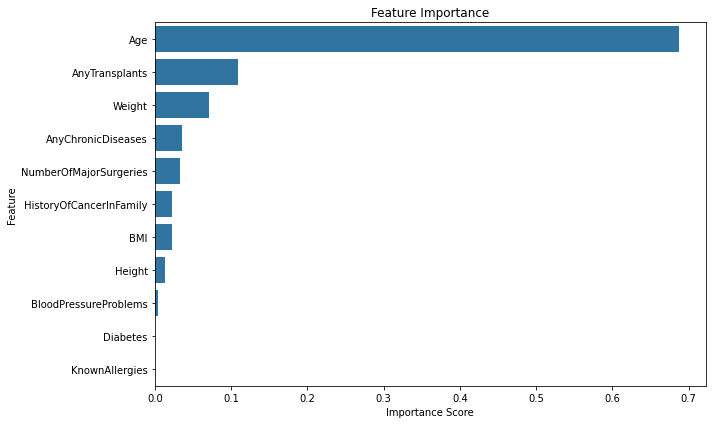

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, X, title="Feature Importance"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Random Forest is assumed best here
plot_feature_importance(final_model, X_train)


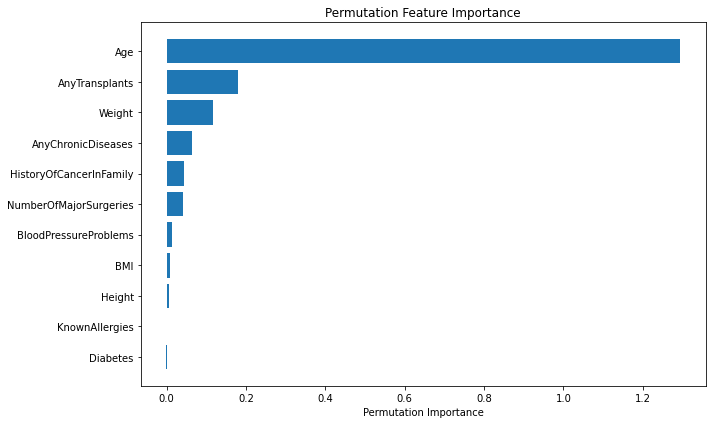

In [35]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X_val, y_val):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(X_val.columns[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Permutation Feature Importance")
    plt.tight_layout()
    plt.show()

# Example with test data
plot_permutation_importance(best_model, X_test, y_test)


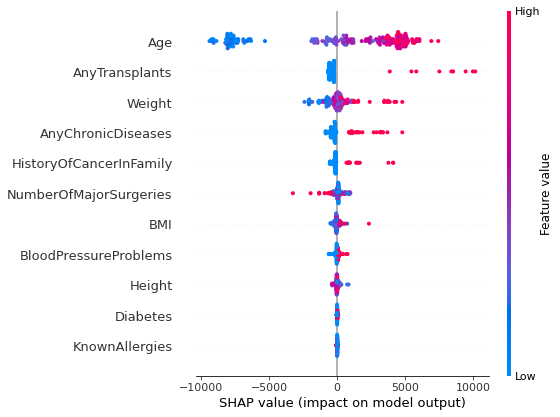

In [49]:
import shap

# Use the older TreeExplainer without check_additivity
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
